### Install necessary libraries

In [1]:
# !pip install langdetect
# !pip install emoji
# !pip install transformers

### Import libraries

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from langdetect import detect
import re
import matplotlib.pyplot as plt
import seaborn as sns

import emoji

import warnings
warnings.filterwarnings("ignore")

### Download nltk packages

In [3]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

### Input files

In [4]:
comments_path = 'Comments.csv'
labelled_path = 'final_labelled_data.csv'

In [5]:
# Loading the data into pandas dataframes
df_comments = pd.read_csv(comments_path)
df_labelled = pd.read_csv(labelled_path)

## Data preprocessing

### Drop these comlumns

In [6]:
df_labelled = df_labelled.dropna(subset=['Topic', 'Comment'])

### Function to check english comments

In [7]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

# Remove non-English comments
df_labelled = df_labelled[df_labelled['Comment'].apply(is_english)]

### Data parameters

In [8]:
# This is the total number of samples you want.
n_samples = 20000

# The number of unique topics.
n_categories = df_labelled['Topic'].nunique()

# Calculate the number of samples per each category.
samples_per_category = n_samples // n_categories

In [9]:
# Now you can create a new dataframe with an equal number of samples from each category.
df_labelled = df_labelled.groupby('Topic').apply(lambda x: x.sample(min(len(x), samples_per_category))).reset_index(drop=True)

### Preprocessing Labelled data

In [10]:
def remove_emoji(text):
    return emoji.demojize(text, delimiters=("", ""))

def preprocess_text(text):
    text = remove_emoji(text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(token) for token in text]
    text = [token for token in text if token.isalnum()]
    return ' '.join(text)

In [11]:
df_labelled['Comment']=df_labelled['Comment'].apply(preprocess_text)

### Convert score to sentiment classes

In [12]:
def score_to_label(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df_labelled['Sentiment_Label'] = df_labelled['Sentiment'].apply(score_to_label)

## Data visualize

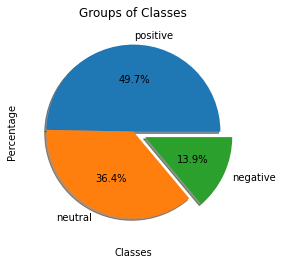

In [13]:
plt.figure(figsize=(8, 4))
df_labelled.groupby('Sentiment_Label')['Sentiment_Label'].count().sort_values(ascending=False).plot(kind='pie', autopct='%1.1f%%', explode=(0, 0, 0.15), shadow=True)
plt.title("Groups of Classes")
plt.ylabel('Percentage')
plt.xlabel('Classes')
plt.show()

**Based on the data, the majority of the classes fall under the "positive" category, accounting for 49.7% of the data. The "neutral" class follows with 36.4%, while the "negative" class represents the smallest portion at 13.9%. This distribution suggests a relatively optimistic sentiment overall, with a significant portion of the data expressing positive opinions or views.**

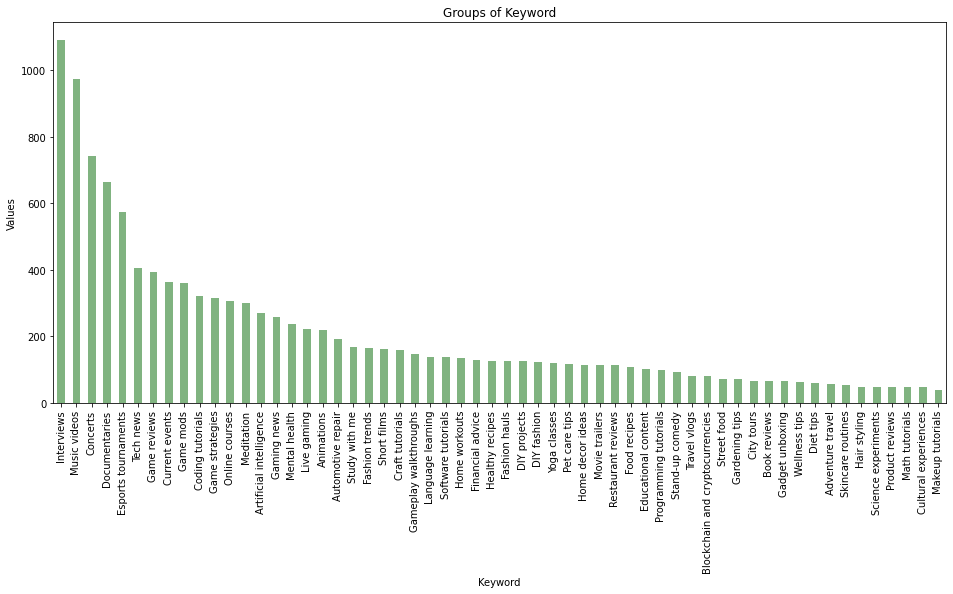

In [14]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Keyword')['Keyword'].count().sort_values(ascending=False).plot(kind='bar', color=(0.5, 0.7, 0.5))
plt.title("Groups of Keyword")
plt.ylabel('Values')
plt.xlabel('Keyword')
plt.show()

**We can observed that the top three keywords with the highest counts are "Interviews," "Music videos," and "Concerts." This suggests a strong interest in media-related content, with a focus on interviews and music-related experiences. Other popular keywords include documentaries, esports tournaments, and tech news, indicating a diverse range of preferences and interests among viewers. Additionally, keywords such as coding tutorials, game strategies, and online courses highlight the popularity of educational and skill-building content in various fields**

In [15]:
df_labelled['Topic'] = df_labelled['Topic'].apply(lambda x: " ".join(x.split('/')[-1].split('_')))

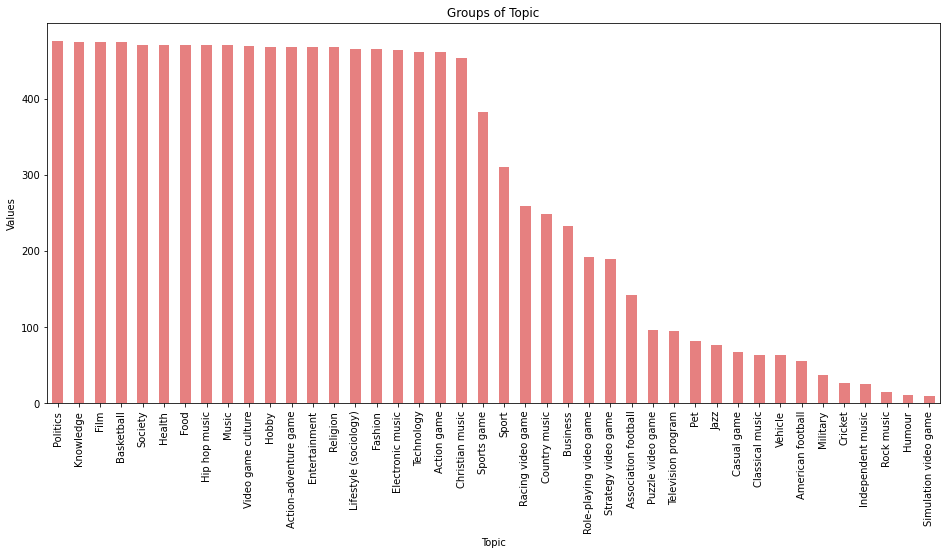

In [16]:
plt.figure(figsize=(16, 7))
df_labelled.groupby('Topic')['Topic'].count().sort_values(ascending=False).plot(kind='bar', color=(0.9, 0.5, 0.5))
plt.title("Groups of Topic")
plt.ylabel('Values')
plt.xlabel('Topic')
plt.show()

**We can observed that the topics with the highest counts are politics, hobby, and film. These three topics seem to generate the most interest and discussions among individuals. Other popular topics include food, knowledge, and action-adventure games, reflecting the diverse range of interests people have.**

## DistilRoBert topic model

### Process comments data

In [18]:
df_comments = df_comments[df_comments['Comment'].apply(is_english)]
df_comments['Comment'] = df_comments['Comment'].apply(preprocess_text)

In [55]:
df_comments.reset_index(drop=True, inplace=True)

### Create class for data preparation

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

class ProcessDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### Load tokenizer and model

In [41]:
model_name = "j-hartmann/emotion-english-distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

### Tokenize texts and create prediction on labelled data

In [42]:
tokenized_texts = tokenizer(list(df_labelled['Comment']), truncation=True, padding=True)
pred_dataset = ProcessDataset(tokenized_texts)

In [44]:
# Run predictions
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)

***** Running Prediction *****
  Num examples = 12046
  Batch size = 16


In [48]:
df_labelled['Topic'] = labels

### Tokenize texts and create prediction on comments data

In [57]:
tokenized_texts = tokenizer(list(df_comments['Comment']), truncation=True, padding=True)
pred_dataset = ProcessDataset(tokenized_texts)

In [58]:
predictions = trainer.predict(pred_dataset)
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)

***** Running Prediction *****
  Num examples = 7052
  Batch size = 16


In [59]:
df_comments['Topic'] = labels

In [60]:
df_labelled

,Video ID,Comment,Keyword,Topic,Sentiment,Sentiment_Label
0,L3VktIOZwZs,me when i get on gorilla tag i am not a king i...,Game mods,surprise,0.000000,neutral
1,cO5e2B7-fxc,storm gate should be a good one,Game strategies,neutral,0.700000,positive
2,cSLBsTfDQH8,happy birthday jesse,Gaming news,joy,0.800000,positive
3,EgbJEC_RLow,thank you i miss playing this i need to get so...,Gameplay walkthroughs,sadness,0.000000,neutral
4,3wqWC7nuhCE,final fantasy tactis is the best,Game strategies,neutral,0.500000,positive
...,...,...,...,...,...,...
12041,N775KsWQVkw,can someone explain why you need to have wsl a...,Coding tutorials,neutral,0.000000,neutral
12042,S63oOMhezNo,i like the noggin one,Game mods,joy,0.000000,neutral
12043,3kbJopmwxbk,what happened to this series would love to see...,Game mods,joy,0.460000,positive
12044,_8xuN7e3SdI,bro how esports company like esl play wa earn ...,Esports tournaments,neutral,0.000000,neutral


In [61]:
df_comments

,Comment,Topic
0,bro iphone 11 new 128gb sahi rahega aya iphone...,neutral
1,keep this series up i luv these kind of walkth...,joy
2,enders game that wa an awesome space movie tha...,joy
3,there a crusader king 2 mod called elder king ...,joy
4,the problem with be careful what you sign is t...,anger
...,...,...
7047,for me richarlyson song wa the best,joy
7048,bro i need a 10 thousand diamond,neutral
7049,big griff always killin it love ya man,anger
7050,shadow ka lag issue solve hoo jaye ba fir miln...,neutral
